# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface, plot_2d_surface, boxplot_stability, lineplot_stability
from src.utils.functions import add_custom_repeating_sequence, add_sequence_to_dataframe, prepare_subsets
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## Parameters

In [29]:
import os
import pandas as pd
import numpy as np

def process_graph_data(dataset_id, data_root):
    """
    Processes SHAP data files by reading them, filtering, and calculating additional metrics.
    
    Parameters:
    - dataset_id: The unique identifier for the dataset.
    - data_root: The root directory where the data files are located.
    
    Returns:
    - df: The processed pandas DataFrame containing selected variables and calculated metrics.
    """
    # Construct file paths
    path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")
    path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
    
    # Read data
    df = pd.read_parquet(path_shap)
    fi_shap_all = pd.read_parquet(path_fi_shap)  # Note: fi_shap_all is read but not used in the provided code
    
    # Filter dataframe
    df = df[(df.n_estimators >= 25) & (df.n_estimators <= 300)]
    
    # Calculate percentiles and stability index
    df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
    df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
    df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))
    df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))
    df['stability index'] = df['shap_stab'].apply(lambda x: np.mean(x))

    # Select variables to keep
    var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'recall', 'model_stab', 'shap_stab', 'shap_q2', 'stability index', 'roc_auc']
    df = df[var]
    # Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
    idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
    # Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
    df = df.loc[idx].reset_index(drop=True)

    return df


def filter_and_select(df, boxplot=False):
    """
    Filters and selects rows from a DataFrame based on specified conditions.
    
    Parameters:
    - df: A pandas DataFrame containing model evaluation metrics and parameters.
    
    Returns:
    - df_filtered: A filtered DataFrame based on the conditions.
    """
    # Define the variables of interest
    var = ['n_estimators', 'n_feats', 'max_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'stability index']
    
    # Filter df1 for specific conditions
    df1_1 = df[
        (df.n_estimators == 100) &
        (df.max_feats == df.max_feats.max())
    ]
    
    # Extract specific metrics from df1_1
    roc = df1_1.roc_auc.iloc[0]
    precision = df1_1.precision.iloc[0]
    recall = df1_1.recall.iloc[0]
    f1_median = df1_1.f1_median.iloc[0]
    
    # Further filter and sort df based on the extracted metrics
    df1_2 = df[var][
        (df.roc_auc >= roc) &
        (df.precision >= precision) & 
        (df.recall >= recall) & 
        (df.f1_median >= f1_median)
    ].sort_values('stability index', ascending=False).drop_duplicates()
    
    # Extract specific feature numbers
    n_feats1 = int(df1_1.n_feats.iloc[0])
    max_feats1 = df.max_feats.max()
    
    n_estimators_2 = int(df1_2.n_estimators.iloc[0])
    n_feats2 = int(df1_2.head(1).n_feats.iloc[0])
    max_feats2 = df1_2.head(1).max_feats.iloc[0]
    
    # Filter df based on the extracted feature numbers
    df_filtered = df[
        ((df.max_feats == max_feats1) & (df.n_feats == n_feats1)) |
        ((df.max_feats == max_feats2) & (df.n_feats == n_feats2))
    ]

    df_filtered_boxplot = df[
        ((df.n_estimators == 100) & (df.max_feats == df.max_feats.max())) |
        ((df.n_estimators == n_estimators_2) & (df.max_feats == max_feats2) & (df.n_feats == n_feats2))
    ]

    if boxplot == False:
        return df_filtered

    else:
        return df_filtered_boxplot

In [30]:
df_fil2 = filter_and_select(df2, boxplot=True)

In [31]:
df_fil2

,n_estimators,max_feats,n_feats,f1_median,precision,recall,model_stab,shap_stab,shap_q2,stability index,roc_auc
39,100,28,28,0.029812,0.015163,0.878173,0.972420,"[0.8036132971199333, 0.7126361018909257, 0.805...",0.766241,0.75493,0.948920
79,200,28,28,0.030095,0.015307,0.888325,0.984625,"[0.8603030445164778, 0.8148732517887649, 0.890...",0.855987,0.84516,0.950136


## Visualization of the results

In [6]:
dataset_id1 = 'arrhythmia'
dataset_id2 = 'creditcard'
dataset_id3 = 'musk'

df1 = process_graph_data(dataset_id1, data_root)
df2 = process_graph_data(dataset_id2, data_root)
df3 = process_graph_data(dataset_id3, data_root)

df_fil1 = filter_and_select(df1)
df_fil2 = filter_and_select(df2)
df_fil3 = filter_and_select(df3)

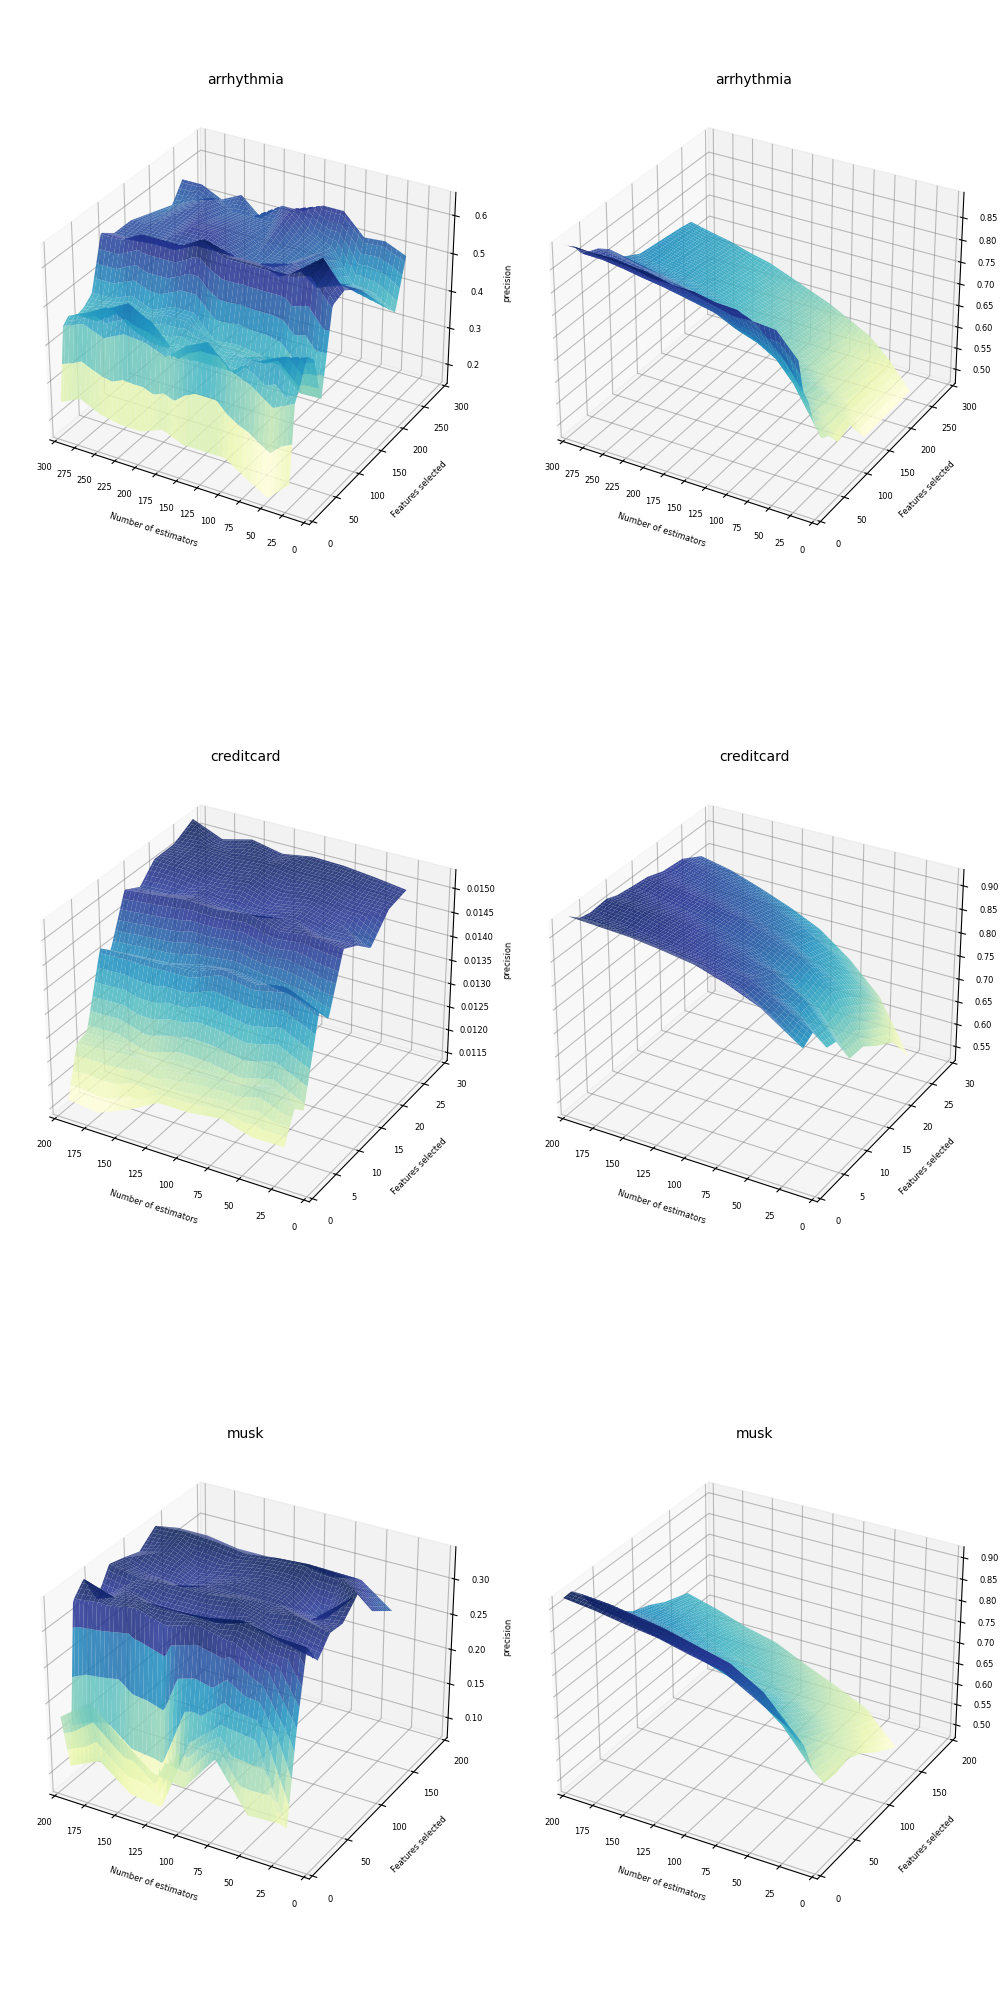

In [7]:
#plt.figure(figsize=(9, 3.8))  # Overall figure size
plt.figure(figsize=(10, 20))  # Overall figure size

# First dataset
ax1 = plt.subplot(3, 2, 1, projection='3d')
plot_3d_surface(df1, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id1}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 2, projection='3d')
plot_3d_surface(df1, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id1}', alpha=.9, edgecolor=None)

# Second dataset
ax1 = plt.subplot(3, 2, 3, projection='3d')
plot_3d_surface(df2, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=5, opt_color='red', title=f'{dataset_id2}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 4, projection='3d')
plot_3d_surface(df2, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=5, opt_color='red', title=f'{dataset_id2}', alpha=.9, edgecolor=None)

# Third dataset
ax1 = plt.subplot(3, 2, 5, projection='3d')
plot_3d_surface(df3, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id3}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 6, projection='3d')
plot_3d_surface(df3, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id3}', alpha=.9, edgecolor=None)

plt.tight_layout()  # Adjust layout


# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust the width space as needed for better visualization

#plt.savefig(image_1, bbox_inches='tight', pad_inches=0.3)  # Save the plot to a file
plt.show()

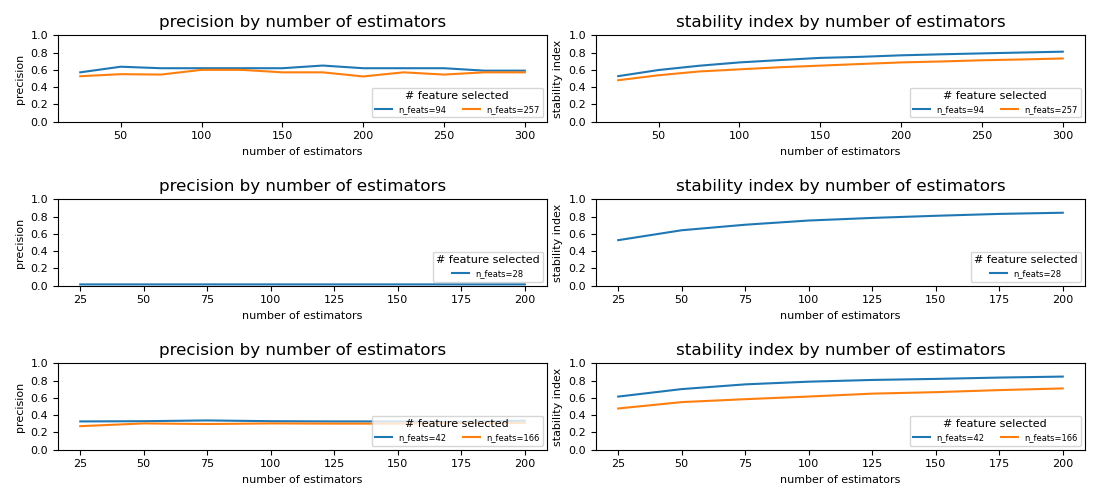

In [12]:
#fig, axs = plt.subplots(2, 2, figsize=(11, 3))  # 1 row, 2 columns

plt.figure(figsize=(11, 5))  # Overall figure size

# First plot
ax1 = plt.subplot(3, 2, 1)
plot_2d_surface(df_fil1, ax1, fontsize_title=12, fontsize_axes=8, feat='precision')
ax2 = plt.subplot(3, 2, 2)
plot_2d_surface(df_fil1, ax2, fontsize_title=12, fontsize_axes=8, feat='stability index')


ax1 = plt.subplot(3, 2, 3)
plot_2d_surface(df_fil2, ax1, fontsize_title=12, fontsize_axes=8, feat='precision')
ax2 = plt.subplot(3, 2, 4)
plot_2d_surface(df_fil2, ax2, fontsize_title=12, fontsize_axes=8, feat='stability index')


ax1 = plt.subplot(3, 2, 5)
plot_2d_surface(df_fil3, ax1, fontsize_title=12, fontsize_axes=8, feat='precision')
ax2 = plt.subplot(3, 2, 6)
plot_2d_surface(df_fil3, ax2, fontsize_title=12, fontsize_axes=8, feat='stability index')


plt.tight_layout()  # Adjust layout

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.1, hspace=0.9)  # Adjust the width space as needed for better visualization

#plt.savefig(image_1, bbox_inches='tight', pad_inches=0.3)  # Save the plot to a file
plt.show()

In [26]:
df_fil1

,n_estimators,max_feats,n_feats,f1_median,precision,recall,model_stab,shap_stab,shap_q2,stability index,roc_auc
6,25,94,94,0.510638,0.571429,0.461538,0.924399,"[0.6056273828477349, 0.5206937230895412, 0.596...",0.524833,0.527256,0.821836
10,25,257,257,0.444444,0.526316,0.384615,0.898469,"[0.48271169539232317, 0.4609238113724704, 0.47...",0.480106,0.479984,0.705955
17,50,94,94,0.583333,0.636364,0.538462,0.965015,"[0.6985915802115005, 0.5955308128896732, 0.638...",0.593991,0.598364,0.822333
21,50,257,257,0.478261,0.550000,0.423077,0.940490,"[0.5320312678904278, 0.5399538564373176, 0.521...",0.535787,0.537484,0.747891
28,75,94,94,0.553191,0.619048,0.500000,0.970786,"[0.7572549672731914, 0.611165789178197, 0.6708...",0.644540,0.647592,0.821092
32,75,257,257,0.500000,0.545455,0.461538,0.964316,"[0.5900515815920844, 0.5851979356131515, 0.569...",0.578885,0.581326,0.768486
39,100,94,94,0.553191,0.619048,0.500000,0.974619,"[0.7822334172504681, 0.662525645489421, 0.6633...",0.684335,0.686292,0.814640
43,100,257,257,0.521739,0.600000,0.461538,0.972078,"[0.622142161434615, 0.6109203511660525, 0.5885...",0.600460,0.606028,0.784615
50,125,94,94,0.553191,0.619048,0.500000,0.976530,"[0.8142261513613139, 0.6781330496954728, 0.688...",0.707659,0.713392,0.816377
54,125,257,257,0.521739,0.600000,0.461538,0.978654,"[0.6644717107263258, 0.6203547821495642, 0.616...",0.623881,0.630377,0.785856
